In [2]:
import datetime
import numpy as np

In [17]:
centerList= [637.40,670.16, 706.20,789.40,761.10, 802.41 ,991.26, 1074.70,1079.80	]

In [31]:
centralWave = 991.26
stepSize = 0.05
waveSteps = 5
cont = "BOTH"
numsums = 16
repeats = 4
exposureTime = 80
LCVRrelaxation = 300
modulations = 4
seconds = 1/1000
cameras =2 

now = datetime.datetime.strftime(datetime.datetime.now(),"%a %b %d %H:%M:%S %Y")
executionTime = (LCVRrelaxation+exposureTime*modulations*numsums)*waveSteps*repeats*cameras*seconds

In [32]:
print(f"{np.floor(centralWave):.0f}_{str(waveSteps).zfill(2)}wave_{stepSize}step_2beam_{numsums}sums_{repeats}reps_{cont}.rcp")
with open(f"{np.floor(centralWave):.0f}_{str(waveSteps).zfill(2)}wave_{stepSize}step_2beam_{numsums}sums_{repeats}reps_{cont}.rcp","w") as f:
    f.write(f"DATE {now}\n")
    f.write(f"AUTHOR: rcp Generator")
    f.write(f"Expected execution time {executionTime:.1f}\n")
    f.write(f"#DATATYPE BEAM  WAVELENGTH  NUMSUMS\n")
    for repeat in range(repeats):
        for cam in ["RCAM","TCAM"]:
            for i in range(waveSteps):
                f.write(f"DATA {cam}\t{((i-np.floor(waveSteps/2))*stepSize)+centralWave:.3f}\t{cont}\t{numsums}\n")
            f.write("\n")

991_05wave_0.05step_2beam_16sums_4reps_BOTH.rcp


In [22]:
for repeat in range(repeats):
    for cam in ["RCAM","TCAM"]:
        for i in range(waveSteps):
            print(f"DATA {cam}\t{((i-np.floor(waveSteps/2))*stepSize)+centralWave:.3f}\t{cont}\t{numsums}\n")
        print("\n")

DATA RCAM	637.330	BOTH	16

DATA RCAM	637.365	BOTH	16

DATA RCAM	637.400	BOTH	16

DATA RCAM	637.435	BOTH	16

DATA RCAM	637.470	BOTH	16



DATA TCAM	637.330	BOTH	16

DATA TCAM	637.365	BOTH	16

DATA TCAM	637.400	BOTH	16

DATA TCAM	637.435	BOTH	16

DATA TCAM	637.470	BOTH	16



DATA RCAM	637.330	BOTH	16

DATA RCAM	637.365	BOTH	16

DATA RCAM	637.400	BOTH	16

DATA RCAM	637.435	BOTH	16

DATA RCAM	637.470	BOTH	16



DATA TCAM	637.330	BOTH	16

DATA TCAM	637.365	BOTH	16

DATA TCAM	637.400	BOTH	16

DATA TCAM	637.435	BOTH	16

DATA TCAM	637.470	BOTH	16



DATA RCAM	637.330	BOTH	16

DATA RCAM	637.365	BOTH	16

DATA RCAM	637.400	BOTH	16

DATA RCAM	637.435	BOTH	16

DATA RCAM	637.470	BOTH	16



DATA TCAM	637.330	BOTH	16

DATA TCAM	637.365	BOTH	16

DATA TCAM	637.400	BOTH	16

DATA TCAM	637.435	BOTH	16

DATA TCAM	637.470	BOTH	16



DATA RCAM	637.330	BOTH	16

DATA RCAM	637.365	BOTH	16

DATA RCAM	637.400	BOTH	16

DATA RCAM	637.435	BOTH	16

DATA RCAM	637.470	BOTH	16



DATA TCAM	637.330	BOTH	16

DATA TCAM	637.

In [123]:
file = open("eclipsePrep.md")
text = file.readlines()
file.close()

In [107]:
exposureTime = 0
for t in text:
    if "data" in t:
        exposureCount += int(t.split("\t")[-1])*80*4+300

In [74]:
import glob
import astropy.io.fits as fits

In [73]:
for recipe in glob.glob(r"C:\\git\\ucomp-configuration\\Recipes\\*.rcp")[0:1]:
    with open(recipe) as rcp:
        for line in rcp.readlines():
            if "DATA" in line:
                line = line.split()
                if len(line) == 4:
                    
        



DATA	RCAM	BOTH	1074.70	16



In [107]:
x = fits.open(r"d:\\20240330.201401.73.ucomp.1074.l0.fts")

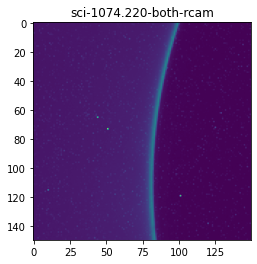

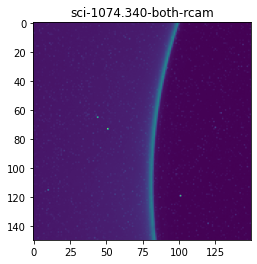

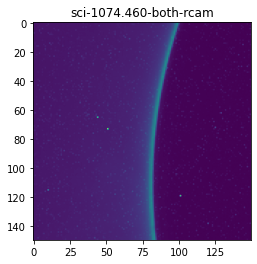

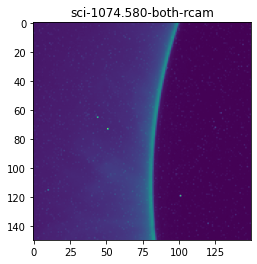

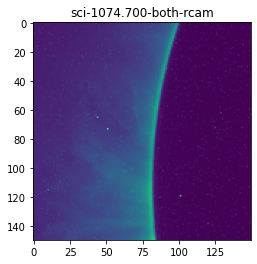

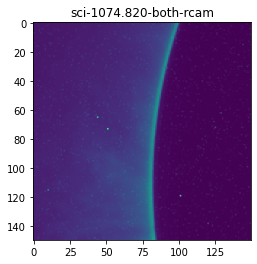

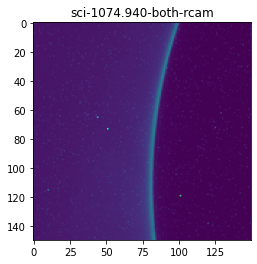

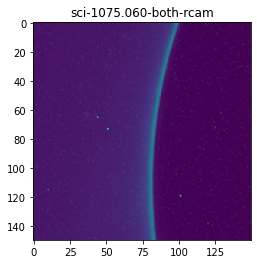

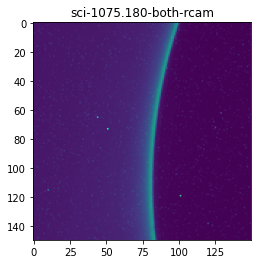

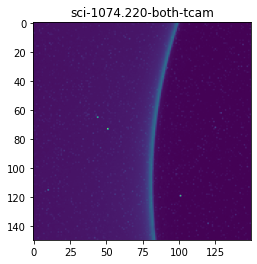

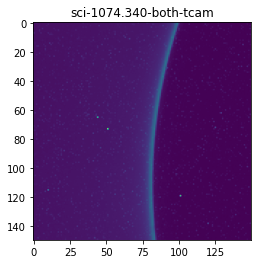

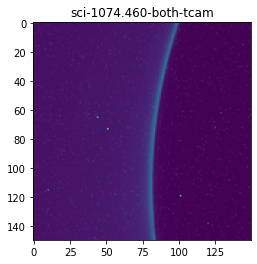

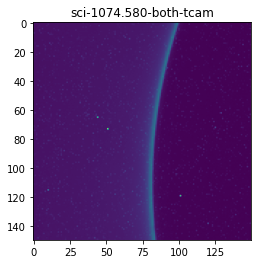

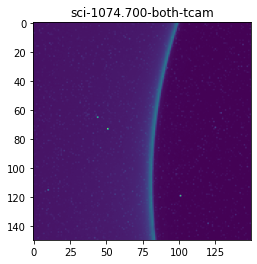

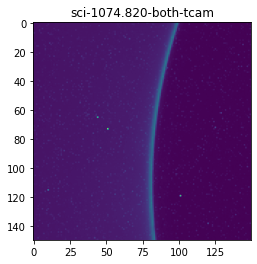

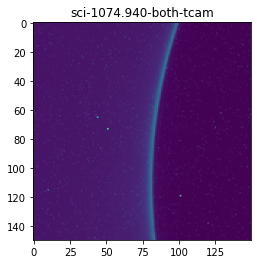

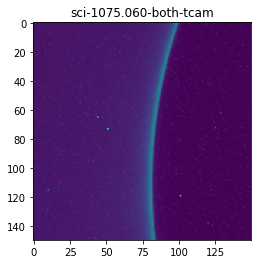

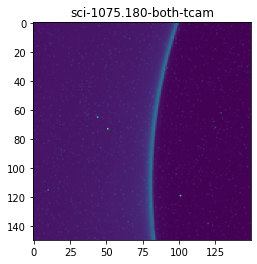

<Figure size 432x288 with 0 Axes>

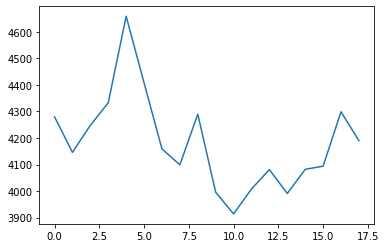

In [108]:
ll = []
for ext in x[1:]:
    plt.imshow(np.sum(ext.data[0,:,400:550,200:350],axis=0))
    plt.title(ext.header['EXTNAME '])
    plt.figure()
    ll.append(np.sum(ext.data[0,:,475,310],axis=0))

plt.figure()
plt.plot(ll)

In [79]:
import matplotlib.pylab as plt

In [80]:
import numpy as np

In [87]:
x[1]

In [85]:
x[1]

In [89]:
ext.header

XTENSION= 'IMAGE   '           / image extension                                
BITPIX  =                   16 / 16-bit two's complement binary integer         
NAXIS   =                    4                                                  
NAXIS1  =                 1280                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                    4                                                  
NAXIS4  =                    2                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
BZERO   =                32768                                                  
BSCALE  =                    1                                                  
O1FOCUS =               61.220 / O1 focus position                              
DATATYPE= 'sci'             